<a href="https://colab.research.google.com/github/kayserena/machine-learning-datathon-6/blob/main/3_Clean_Final_Project_Naive_Bayes_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Loading Libraries and Data

In [ ]:
import pandas as pd
from sklearn import datasets
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import random
# !pip install missingno
import missingno as msno
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

In [ ]:
df = pd.read_excel('Diabetes Study File 10K Dec 14 2017.xlsx')
df.head()

,Age_at_Exam,sBP,sBP_Date,BMI,BMI_Date,LDL,LDL_Date,HDL,HDL_Date,A1c,...,leastO(A1c_Date),leastO(DM_OnsetDate),leastO(FBS_Date),LeastOfAll,A1C_BEF_DM,FBS_BEF_DM,Patient_ID,DM_Onset_Revised,DM_Onset_Revised_1YrPrior,DIABETES
0,65,126.0,2013-06-11,31.000000,2013-06-11,1.66,2013-06-14,1.11,2013-06-14,5.4,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000255903,NaT,NaT,No
1,62,135.0,2014-06-19,25.846483,2014-10-17,2.49,2014-05-28,1.37,2014-05-28,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000256456,NaT,NaT,No
2,63,133.0,2012-07-31,30.900000,2011-12-01,1.65,2012-06-01,NaN,NaT,6.1,...,NaN,NaN,NaN,NaN,NaN,NaN,1001000000000054,NaT,NaT,No
3,51,136.0,2014-01-06,56.710775,2014-01-06,2.80,2014-01-14,1.94,2014-01-14,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000259496,NaT,NaT,No
4,40,123.0,2015-06-12,33.067867,2015-06-12,2.48,2015-06-24,1.17,2015-06-24,5.8,...,NaN,NaN,NaN,NaN,NaN,NaN,4001000000262094,NaT,NaT,No


# 2.0 Data Preparation

In [ ]:
# Splitting the original dataset into training, validation, and test sets

# Taking 70% of the data for training
train_df = df.sample(frac = 0.7)

# Removing the training data from the original dataset to get the combined validation and test data
test_df = df.drop(train_df.index)

# Splitting the combined validation and test data into two equal parts for validation and testing, respectively
valid_df = test_df.sample(frac = 0.5)
test_df = test_df.drop(valid_df.index)

# Use SimpleImputer to compute the median of 'LDL' in the training set
imputer = SimpleImputer(strategy='median')
## By filling missing values with the median, we are using a central value that is less sensitive to
#outliers compared to the mean. This is a common strategy for imputing missing numerical data because
#it can help preserve the overall distribution of the data.

# Use this mean to fill the NaN values in both training, validation, and test sets
imputer.fit(train_df[["sBP"]])
train_df["sBP"] = imputer.transform(train_df[['sBP']])
valid_df["sBP"] = imputer.transform(valid_df[['sBP']])
test_df['sBP'] = imputer.transform(test_df[['sBP']])

imputer.fit(train_df[["LDL"]])
train_df["LDL"] = imputer.transform(train_df[['LDL']])
valid_df["LDL"] = imputer.transform(valid_df[['LDL']])
test_df['LDL'] = imputer.transform(test_df[['LDL']])

imputer.fit(train_df[["TG"]])
train_df["TG"] = imputer.transform(train_df[['TG']])
valid_df["TG"] = imputer.transform(valid_df[['TG']])
test_df['TG'] = imputer.transform(test_df[['TG']])

imputer.fit(train_df[["Total_Cholesterol"]])
train_df["Total_Cholesterol"] = imputer.transform(train_df[['Total_Cholesterol']])
valid_df["Total_Cholesterol"] = imputer.transform(valid_df[['Total_Cholesterol']])
test_df['Total_Cholesterol'] = imputer.transform(test_df[['Total_Cholesterol']])

# 3.0 Gaussian Naive Bayes Classifier Building

## 3.1 Definining utility functions for model evaluation

In [ ]:
def get_scores(Y, Y_pred):
    """
    Computes various evaluation metrics for model predictions.

    Parameters:
    - Y: Actual target values.
    - Y_pred: Predicted target values by the model.

    Returns:
    - conf_matrix: Confusion matrix showing true positives, true negatives, false positives, and false negatives.
    - class_report: Classification report detailing precision, recall, and F1-score for each class.
    - auc: Area Under the Curve (AUC) value for the model's predictions.
    - acc: Accuracy of the model's predictions.
    """
    conf_matrix = confusion_matrix(Y, Y_pred)
    class_report = classification_report(Y, Y_pred)
    auc = roc_auc_score(Y, Y_pred)
    acc = accuracy_score(Y, Y_pred)

    return conf_matrix, class_report, auc, acc

def print_scores(conf_matrix, class_report, auc, acc):
    """
    Prints the evaluation metrics in a structured format.

    Parameters:
    - conf_matrix: Confusion matrix from get_scores function.
    - class_report: Classification report from get_scores function.
    - auc: AUC value from get_scores function.
    - acc: Accuracy value from get_scores function.
    """
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

## 3.2 Evaluating Gausssian Naive Bayes Model on Training Data

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


AUC :  0.8106235060237726
Accuracy :  0.8097142857142857
Confusion Matrix:
[[2887  524]
 [ 808 2781]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      3411
           1       0.84      0.77      0.81      3589

    accuracy                           0.81      7000
   macro avg       0.81      0.81      0.81      7000
weighted avg       0.81      0.81      0.81      7000



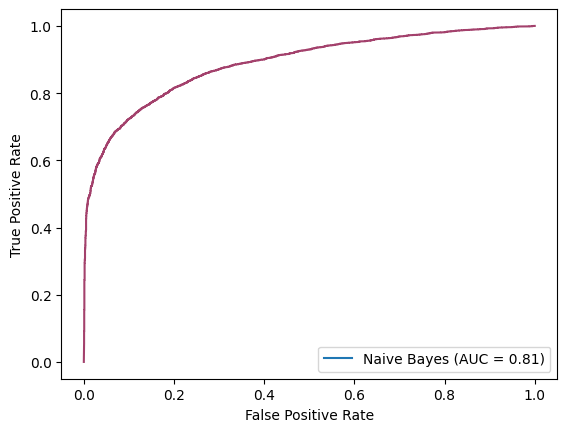

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import RocCurveDisplay, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, classification_report

continuous_variables = ["Age_at_Exam", "sBP", "BMI", "LDL", "A1c", "TG", "Total_Cholesterol"]

# Training a Gaussian Naive Bayes model for continuous variables
gnb = GaussianNB()
gnb = gnb.fit(train_df[continuous_variables].to_numpy(), train_df["Diabetes"])

# Getting log probabilities for Gaussian model
y_hat_prob = gnb.predict_proba(train_df[continuous_variables])

# Getting predicted values
y_hat = gnb.predict(train_df[continuous_variables])

# Evaluate the combined model using custom functions
conf_matrix, class_report, auc, acc = get_scores(train_df['Diabetes'], y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(train_df['Diabetes'], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#a3416c')

## 3.3 Evaluating Gausssian Naive Bayes Model on Validation Data

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


AUC :  0.8248614972031975
Accuracy :  0.824
Confusion Matrix:
[[596 113]
 [151 640]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       709
           1       0.85      0.81      0.83       791

    accuracy                           0.82      1500
   macro avg       0.82      0.82      0.82      1500
weighted avg       0.83      0.82      0.82      1500



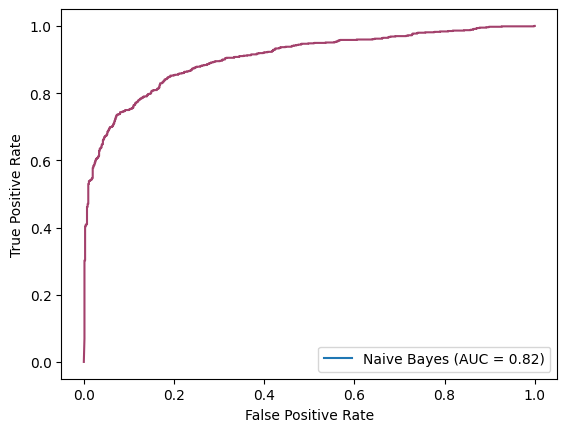

In [ ]:
# Training a Gaussian Naive Bayes model for continuous variables
gnb = GaussianNB()
gnb = gnb.fit(valid_df[continuous_variables].to_numpy(), valid_df["Diabetes"])

# Getting log probabilities for Gaussian model
y_hat_prob = gnb.predict_proba(valid_df[continuous_variables])

# Getting predicted values
y_hat = gnb.predict(valid_df[continuous_variables])

# Evaluate the combined model using custom functions
conf_matrix, class_report, auc, acc = get_scores(valid_df['Diabetes'], y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(valid_df['Diabetes'], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#a3416c')

## 3.4 Evaluating Gausssian Naive Bayes Model on Testing Data

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


AUC :  0.8153120716049778
Accuracy :  0.8146666666666667
Confusion Matrix:
[[644  97]
 [181 578]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       741
           1       0.86      0.76      0.81       759

    accuracy                           0.81      1500
   macro avg       0.82      0.82      0.81      1500
weighted avg       0.82      0.81      0.81      1500



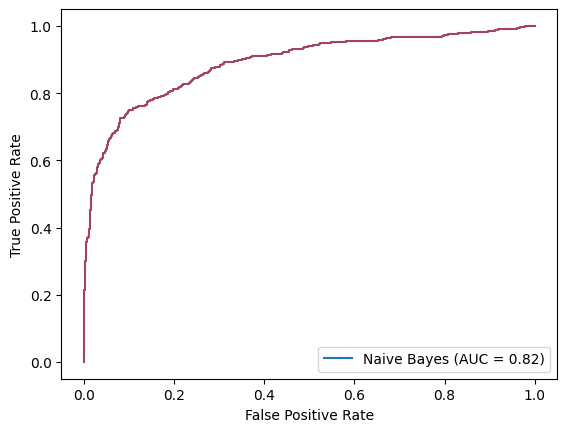

In [ ]:
# Training a Gaussian Naive Bayes model for continuous variables
gnb = GaussianNB()
gnb = gnb.fit(test_df[continuous_variables].to_numpy(), test_df["Diabetes"])

# Getting log probabilities for Gaussian model
y_hat_prob = gnb.predict_proba(test_df[continuous_variables])

# Getting predicted values
y_hat = gnb.predict(test_df[continuous_variables])

# Evaluate the combined model using custom functions
conf_matrix, class_report, auc, acc = get_scores(test_df['Diabetes'], y_hat)
print_scores(conf_matrix, class_report, auc, acc)

# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(test_df['Diabetes'], y_hat_prob[:, 1])
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Naive Bayes')
display.plot()
ax = plt.gca()
ax.get_lines()[0].set_color('#a3416c')